In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from psynlig import pca_loadings_map
from psynlig import pca_explained_variance_bar

from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
color_mapping12 = {
    "C>A": "deepskyblue",
    "G>T": "deepskyblue",
    "C>G": "black",
    "G>C": "black",
    "C>T": "red",
    "G>A": "red",
    "T>A": "silver",
    "A>T": "silver",
    "T>C": "yellowgreen",
    "A>G": "yellowgreen",
    "T>G": "pink",
    "A>C": "pink",
}
sbs12_ordered = ["C>A", "G>T", "C>G", "G>C", "C>T", "G>A", "T>A", "A>T", "T>C", "A>G", "T>G", "A>C"]
colors12 = [color_mapping12[sbs] for sbs in sbs12_ordered]

In [3]:
virus_df = pd.read_csv('./data/viral_spectra_dataset.csv')
virus_df.head()

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,Type,taxname,df,taxid,virusname
0,0.109127,0.117342,0.073464,0.060217,0.011690,0.149450,0.196651,0.026968,0.020779,0.036932,0.132424,0.064957,ds,Hepatitis B virus,nemu,10407,HBV
1,0.034784,0.086621,0.027108,0.044784,0.006846,0.339187,0.234664,0.000000,0.102792,0.009995,0.095861,0.017356,ds,Rice black streaked dwarf virus,nemu,10990,RBSDV
2,0.012922,0.127692,0.009847,0.022595,0.001792,0.379747,0.123494,0.003866,0.031890,0.022814,0.249177,0.014165,+,West Nile virus,nemu,11082,WNV
3,0.009244,0.183506,0.025201,0.014157,0.002805,0.243095,0.227613,0.012168,0.021287,0.031341,0.224274,0.005309,+,Norwalk virus,nemu,11983,norw
4,0.008840,0.102109,0.025178,0.031668,0.010016,0.490211,0.153864,0.018815,0.025828,0.020681,0.106414,0.006376,+,Hepatovirus A,nemu,12092,HAV


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd

# Features and target (use existing variables in the notebook)
X = virus_df[sbs12_ordered]
y = virus_df['Type']

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# Logistic regression pipeline (standardize + multinomial logistic regression)
logreg_pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000, random_state=42, fit_intercept=False)
)

# Dummy classifier (most frequent) as reference
dummy_pipe = make_pipeline(
    StandardScaler(),  # scaling doesn't affect dummy but keeps pipelines comparable
    DummyClassifier(strategy='most_frequent', random_state=42)
)

# Cross-validate both models
scores_logreg = cross_validate(logreg_pipe, X, y, cv=cv, scoring=scoring, return_train_score=False)
scores_dummy = cross_validate(dummy_pipe, X, y, cv=cv, scoring=scoring, return_train_score=False)

# Summarize CV results
def summarize_scores(scores, name):
    out = {}
    for metric in scoring:
        vals = scores[f'test_{metric}']
        out[metric] = (np.mean(vals), np.std(vals))
        print(f"{name} {metric}: {np.mean(vals):.3f} ± {np.std(vals):.3f}")
    print()
    return out

print("Cross-validation performance")
res_logreg = summarize_scores(scores_logreg, "LogReg")
res_dummy = summarize_scores(scores_dummy, "Dummy")

# Fit logistic regression on entire dataset to inspect coefficients
logreg_pipe.fit(X, y)
logreg = logreg_pipe.named_steps['logisticregression']

# Coefficients: shape (n_classes, n_features)
coef = logreg.coef_
classes = logreg.classes_
feature_names = list(X.columns)

# Overall importance: mean absolute coefficient across classes
mean_abs_coef = np.mean(np.abs(coef), axis=0)
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_coef': mean_abs_coef
}).sort_values('mean_abs_coef', ascending=False).reset_index(drop=True)

print("Top features by mean absolute coefficient (overall importance):")
print(feat_imp_df.head(10).to_string(index=False))
print()

# Per-class top positive coefficients (features that increase log-odds for the class)
top_k = 5
for i, cls in enumerate(classes):
    class_coefs = coef[i]
    top_idx = np.argsort(class_coefs)[-top_k:][::-1]
    top_feats = [(feature_names[j], class_coefs[j]) for j in top_idx]
    print(f"Top {top_k} positive features for class '{cls}':")
    for fname, val in top_feats:
        print(f"  {fname}: {val:.4f}")
    print()

# Also show top absolute contributors per class
for i, cls in enumerate(classes):
    class_coefs = coef[i]
    top_idx = np.argsort(np.abs(class_coefs))[-top_k:][::-1]
    top_feats = [(feature_names[j], class_coefs[j]) for j in top_idx]
    print(f"Top {top_k} absolute-contribution features for class '{cls}':")
    for fname, val in top_feats:
        print(f"  {fname}: {val:.4f}")
    print()

Cross-validation performance
LogReg accuracy: 0.786 ± 0.060
LogReg precision_macro: 0.683 ± 0.119
LogReg recall_macro: 0.711 ± 0.038
LogReg f1_macro: 0.667 ± 0.058

Dummy accuracy: 0.518 ± 0.077
Dummy precision_macro: 0.173 ± 0.026
Dummy recall_macro: 0.333 ± 0.000
Dummy f1_macro: 0.226 ± 0.024

Top features by mean absolute coefficient (overall importance):
feature  mean_abs_coef
    G>A       0.820248
    A>C       0.559392
    C>A       0.495781
    A>T       0.488863
    C>T       0.453870
    G>C       0.361455
    T>C       0.344987
    T>G       0.271230
    G>T       0.201992
    A>G       0.197332

Top 5 positive features for class '+':
  A>T: 0.7333
  C>T: 0.6591
  G>C: 0.5343
  T>C: 0.5175
  G>T: 0.3030

Top 5 positive features for class '-':
  G>A: 1.0454
  C>A: 0.7437
  C>G: 0.2078
  T>G: 0.1696
  G>C: 0.0079

Top 5 positive features for class 'ds':
  A>C: 0.8391
  A>G: 0.2960
  T>G: 0.2372
  G>A: 0.1850
  C>T: 0.0217

Top 5 absolute-contribution features for class '+':
  

In [8]:
import eli5
from eli5.sklearn import PermutationImportance

eli5.show_weights(logreg, feature_names=feature_names, top=15, target_names=classes)

In [7]:
perm = PermutationImportance(logreg, random_state=42)
perm.fit(X, y)
eli5.show_weights(perm, feature_names=feature_names, top=15, target_names=classes, targets=[0, 1, 2], )

Weight,Feature
0.3514 ± 0.1233,G>A
0.1189 ± 0.0551,T>C
0.0757 ± 0.1102,C>T
0.0486 ± 0.0717,A>G
0.0432 ± 0.0432,A>C
0.0324 ± 0.0865,G>T
0.0324 ± 0.0405,T>G
0.0216 ± 0.0630,A>T
0.0216 ± 0.0630,C>A
0 ± 0.0000,T>A


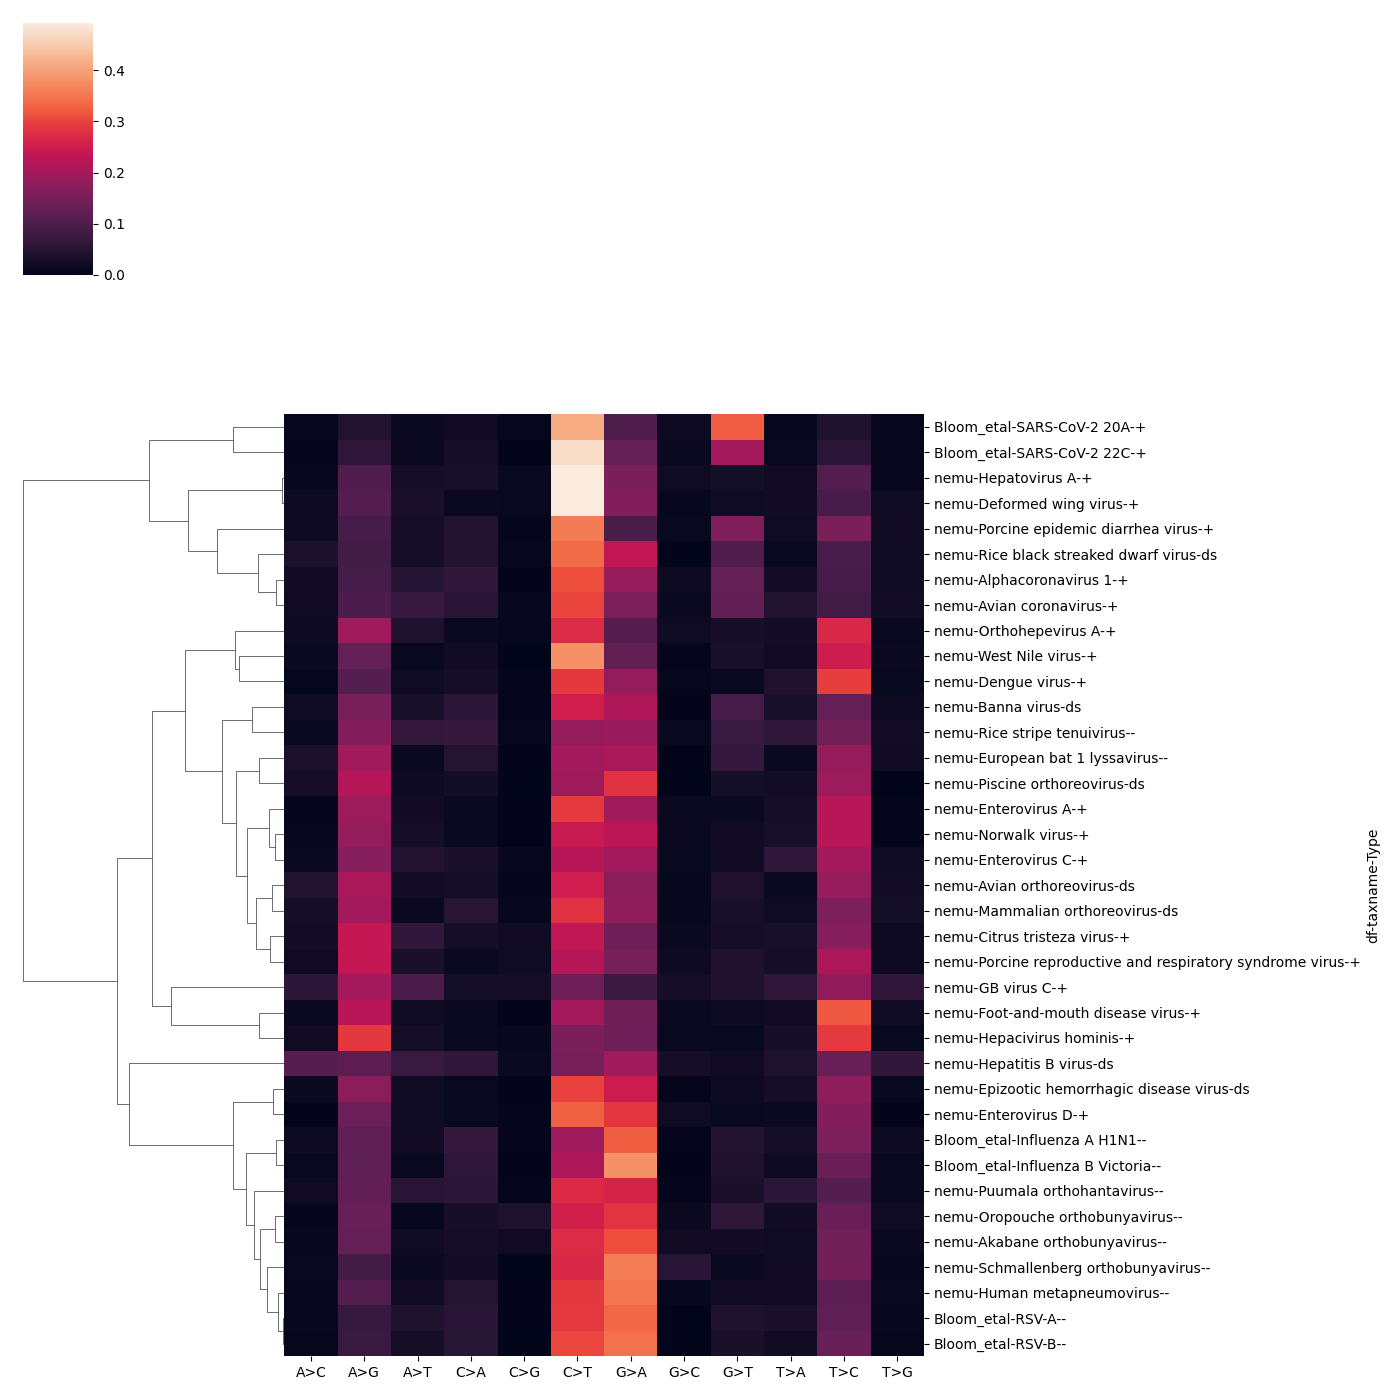

In [4]:
g = sns.clustermap(virus_df.set_index(['df', 'taxname', 'Type']).drop(['taxid', 'virusname'],axis=1),
               metric='cosine', col_cluster=False, figsize=(14, 14), dendrogram_ratio=0.3
              )
# g.savefig('../viral_spectra/figures/viruses_clustermap.pdf')

## PCA

In [5]:
pca_data_only = virus_df[sbs12_ordered]
pca_data_only.head()

,C>A,G>T,C>G,G>C,C>T,G>A,T>A,A>T,T>C,A>G,T>G,A>C
0,0.060217,0.020779,0.011690,0.026968,0.149450,0.196651,0.036932,0.073464,0.132424,0.117342,0.064957,0.109127
1,0.044784,0.102792,0.006846,0.000000,0.339187,0.234664,0.009995,0.027108,0.095861,0.086621,0.017356,0.034784
2,0.022595,0.031890,0.001792,0.003866,0.379747,0.123494,0.022814,0.009847,0.249177,0.127692,0.014165,0.012922
3,0.014157,0.021287,0.002805,0.012168,0.243095,0.227613,0.031341,0.025201,0.224274,0.183506,0.005309,0.009244
4,0.031668,0.025828,0.010016,0.018815,0.490211,0.153864,0.020681,0.025178,0.106414,0.102109,0.006376,0.008840


In [6]:
model = PCA(n_components=12).fit(pca_data_only)
pca_model = model.transform(pca_data_only)
#pca_model = pca.fit_transform(pca_data_only)
pca_data = pd.DataFrame(pca_model, columns=["pc"+str(i+1) for i in range(len(pca_data_only.columns))])
pca_data1 = pca_data[["pc1","pc2"]].copy()

In [7]:
pca_data_plot = pca_data1.copy()

In [8]:
pca_data_plot['Type'] = virus_df['Type']
pca_data_plot['taxname'] = virus_df['taxname']
pca_data_plot['virusname'] = virus_df['virusname']
pca_data_plot['df'] = virus_df['df']

In [9]:
pca_data_plot.head()

,pc1,pc2,Type,taxname,virusname,df
0,-0.082986,0.016483,ds,Hepatitis B virus,HBV,nemu
1,0.112329,0.036784,ds,Rice black streaked dwarf virus,RBSDV,nemu
2,0.036989,-0.101392,+,West Nile virus,WNV,nemu
3,-0.081476,-0.000148,+,Norwalk virus,norw,nemu
4,0.181605,-0.043581,+,Hepatovirus A,HAV,nemu


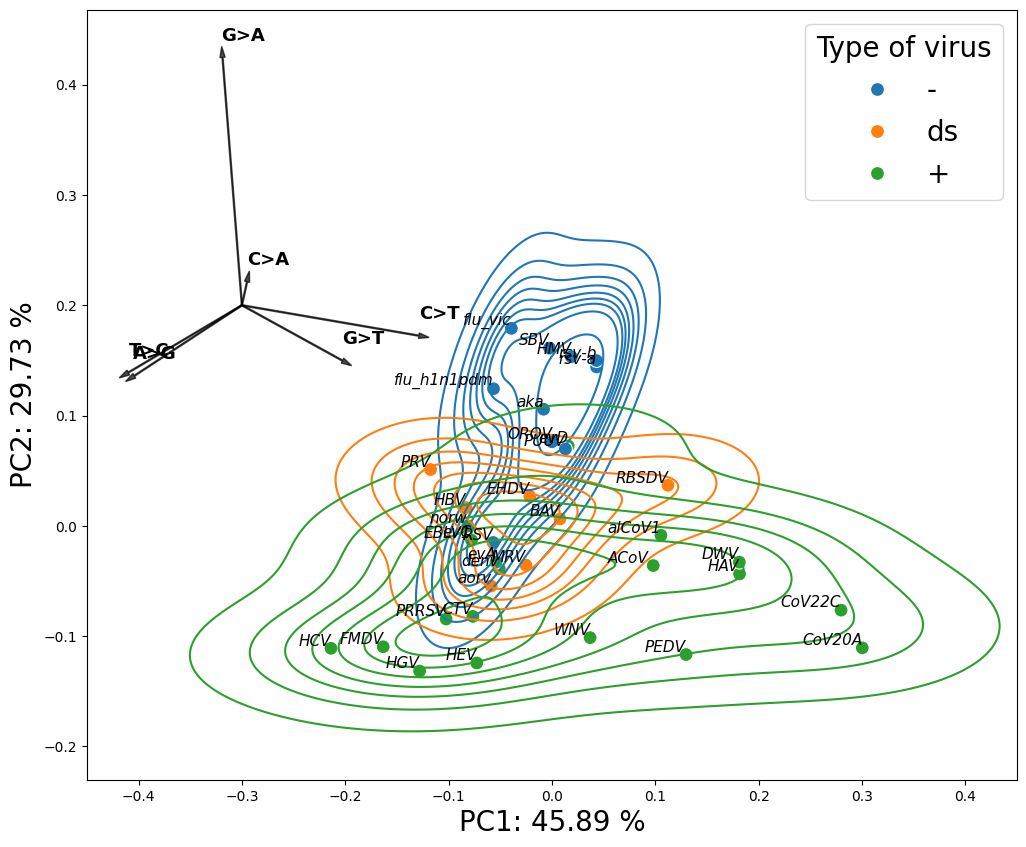

In [53]:
plt.figure(figsize=(12, 10))
sns.kdeplot(pca_data_plot, x='pc1', y='pc2', hue='Type',  hue_order=['-', 'ds', '+'])
ax = sns.scatterplot(pca_data_plot, x='pc1', y='pc2', hue='Type', hue_order=['-', 'ds', '+'], s=100)

for _, row in pca_data_plot.iterrows():
    ax.text(row['pc1'], row['pc2'], row['virusname'], fontsize=11, style='oblique', ha='right', va='bottom')

# Calculate the projections of the original features (columns) onto the PCA plot
# Use the loadings (PCA components) for PC1 and PC2
feature_vectors = model.components_[:2, :]  # shape (2, 12)
scaling = 0.25  # scale factor for better visualization

for i, feature in enumerate(sbs12_ordered):
    x = feature_vectors[0, i] * scaling
    y = feature_vectors[1, i] * scaling
    if (x**2 + y**2)**0.5 < 0.02:  # filter out small vectors
        continue
    ax.arrow(-0.3, 0.2, x, y, color='k', alpha=0.7, head_width=0.005, head_length=0.01, linewidth=1)
    ax.text((x-0.28), (y+0.22), feature, color='black', ha='center', va='center', fontsize=13, fontweight='bold')

ax.set_xlim(-0.45, 0.45)

ax.set_xlabel('PC1: {:.2f} %'.format(model.explained_variance_ratio_[0]*100), fontsize=20)
ax.set_ylabel('PC2: {:.2f} %'.format(model.explained_variance_ratio_[1]*100), fontsize=20)

plt.legend(title='Type of virus', fontsize=20, title_fontsize=20)
plt.savefig('./figures/PCA_virus_cds.pdf', bbox_inches='tight', pad_inches=0.7)

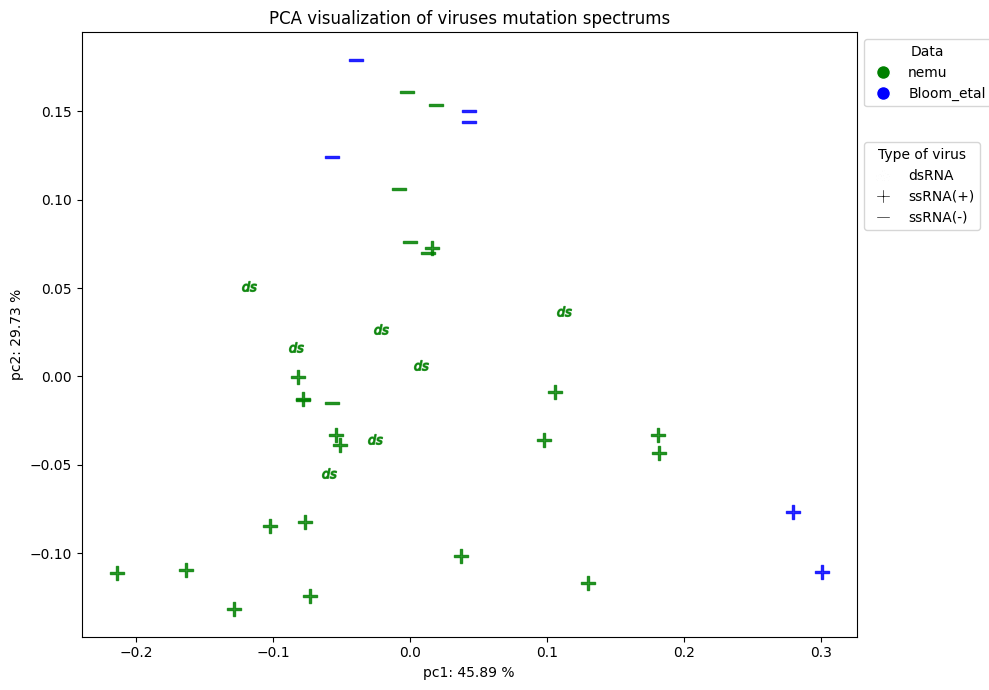

In [11]:
colors = {'nemu':'g', 'Bloom_etal':'b'}
markers={'ds':'$ds$', '+':'$+$', '-':'$-$'}
types_rna_virus = ['dsRNA', 'ssRNA(+)', 'ssRNA(-)']

# Create plot
fig, ax = plt.subplots(figsize=(10,7))

# Displaying points using colors and markers
for df in pca_data_plot['df'].unique():
    for Type in pca_data_plot['Type'].unique():
        indices = (pca_data_plot['df'] == df) & (pca_data_plot['Type'] == Type)
        ax.scatter(pca_data_plot.loc[indices, 'pc1'], pca_data_plot.loc[indices, 'pc2'],
                   s=100, # dot size
                   alpha=0.8, # непрозрачность
                   c=colors[df], # цвет точки
                   marker=markers[Type] # форма точки
                   )

# Отображаем легенду для цвета
handles_color = [plt.Line2D([0], [0], marker='o', color='w', label=color, markerfacecolor=colors[color], markersize=10) for color in colors]
legend_color = ax.legend(handles=handles_color, title="Data", loc="upper left", bbox_to_anchor=(1, 1))

# Добавляем легенду для типов маркеров
handles_marker = [plt.Line2D([0], [0], marker=markers[marker], color='w', label=type_rna_vir, markerfacecolor='k', markersize=10) for type_rna_vir, marker in zip(types_rna_virus, markers)]
legend_marker = ax.legend(handles=handles_marker, title="Type of virus", loc="upper left", bbox_to_anchor=(1, 0.83))

# # Добавляем обе легенды
ax.add_artist(legend_color)
# ax.add_artist(legend_marker)

ax.set_xlabel('pc1: {:.2f} %'.format(model.explained_variance_ratio_[0]*100))
ax.set_ylabel('pc2: {:.2f} %'.format(model.explained_variance_ratio_[1]*100))
ax.set_title('PCA visualization of viruses mutation spectrums')

# plt.subplots_adjust(right=0.7)
fig.tight_layout()
plt.show()

# fig.savefig('../viral_spectra/figures/PCA_nemu_kelly.pdf', bbox_inches='tight', pad_inches=0.7)

## Mutations that most affected components

In [12]:
n_pcs= model.components_.shape[0]
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

In [13]:
initial_feature_names = list(pca_data_only.columns)
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

df = pd.DataFrame(dic.items())

In [14]:
df

,0,1
0,PC1,C>T
1,PC2,G>A
2,PC3,C>T
3,PC4,G>T
4,PC5,A>G
5,PC6,A>C
6,PC7,C>A
7,PC8,C>G
8,PC9,G>C
9,PC10,T>A


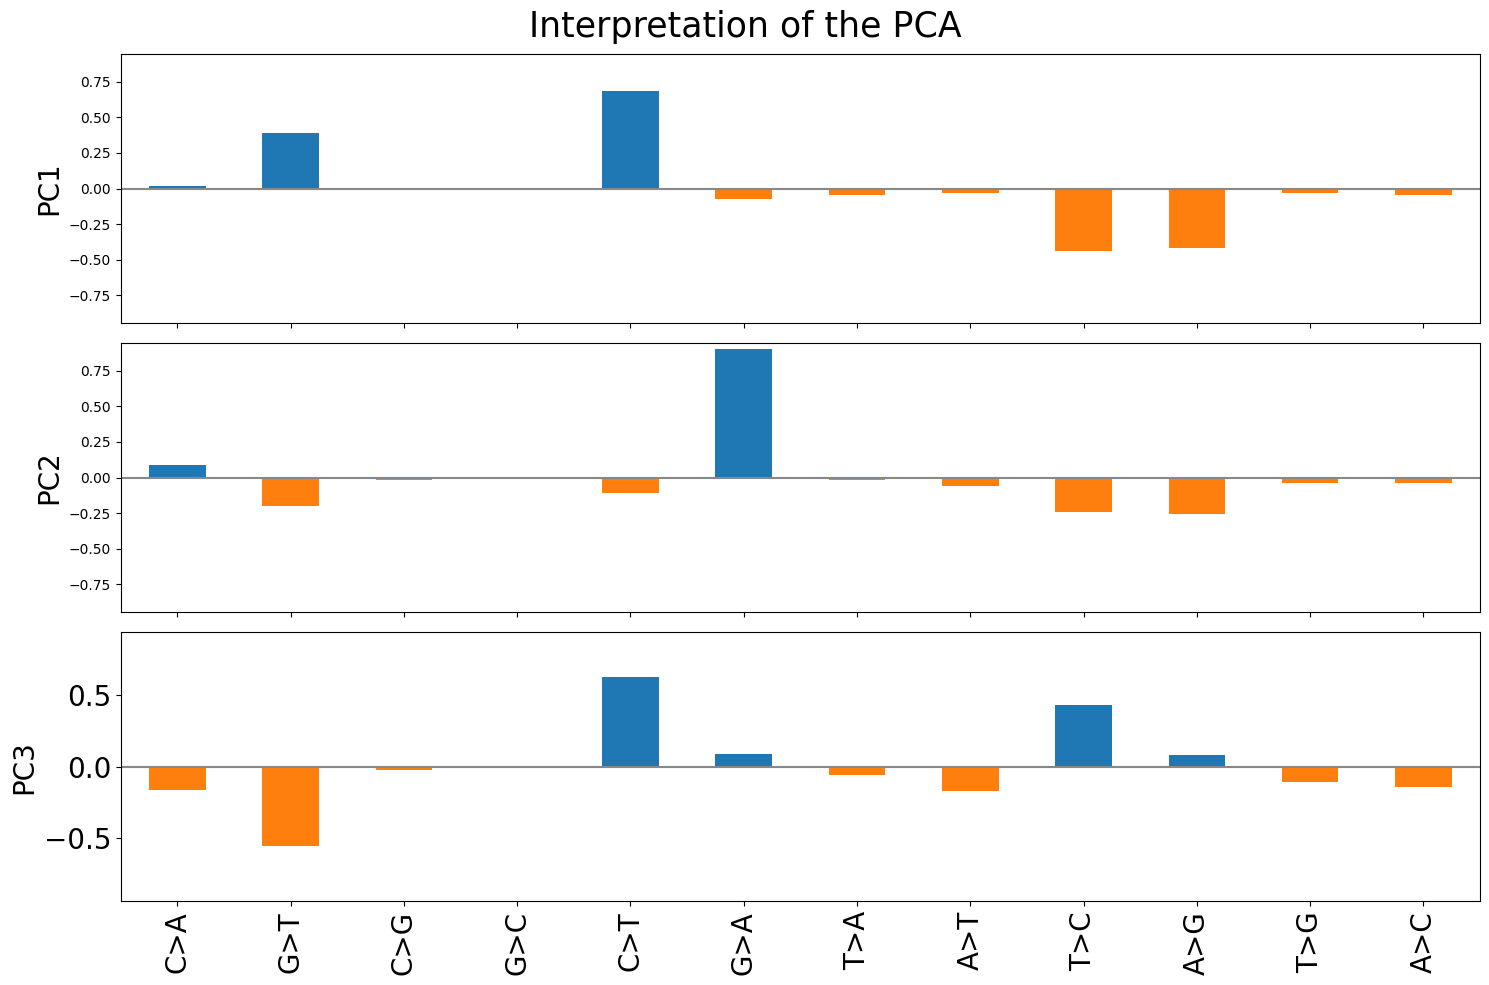

In [15]:
loadings = pd.DataFrame(model.components_[0:3, :], 
                        columns=pca_data_only.columns)
maxPC = 1.05 * np.max(np.max(np.abs(loadings.loc[0:3, :])))
f, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}', fontsize=20)
    ax.set_ylim(-maxPC, maxPC)
plt.suptitle('Interpretation of the PCA', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
plt.show()

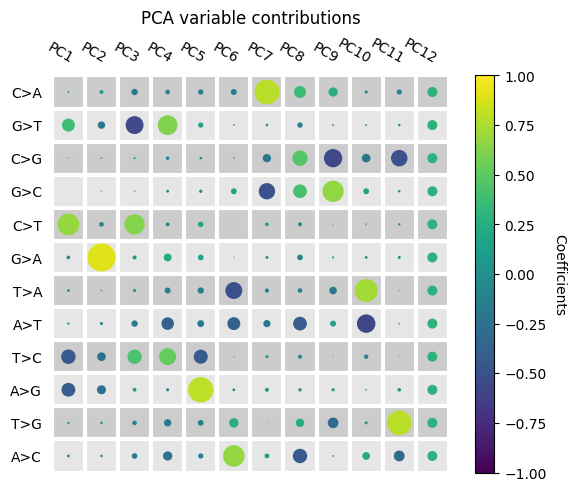

In [16]:
kwargs = {
    'heatmap': {
        'vmin': -1,
        'vmax': 1,
    },
}



pca_loadings_map(
    model,
    pca_data_only.columns,
    bubble=True,
    annotate=False,
    **kwargs
)
plt.suptitle('PCA variable contributions')
plt.show()

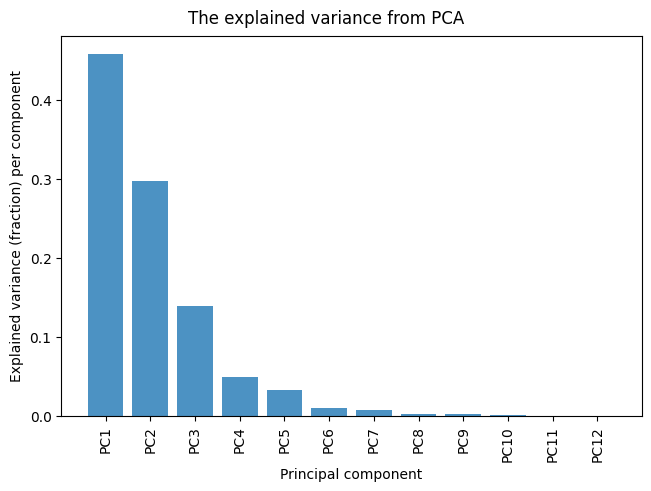

In [17]:
pca_explained_variance_bar(model, alpha=0.8)
plt.suptitle('The explained variance from PCA')
plt.show()

## PCA with complement ssRNA-

In [54]:
from pymutspec.annotation import transcriptor

In [55]:
linages = pd.read_csv('./data/vir_linages.csv', 
                      usecols=['taxid', 'family'], 
                      dtype={'taxid': str, 'family': str})
linages

,taxid,family
0,694009,Coronaviridae__11118
1,11320,Orthomyxoviridae__11308
2,11103,Flaviviridae__11050
3,11983,Caliciviridae__11974
4,12637,Flaviviridae__11050
...,...,...
90,33760,Bromoviridae__39740
91,12844,Potyviridae__39729
92,12169,Betaflexiviridae__675068
93,2560743,Peribunyaviridae__1980416


In [56]:
virus_df.merge(linages, on='taxid', how='left').query('family == "Coronaviridae__11118"')

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,Type,taxname,df,taxid,virusname,family
8,0.017020,0.091356,0.028301,0.044811,0.004483,0.357214,0.095441,0.009720,0.158906,0.017986,0.153859,0.020902,+,Porcine epidemic diarrhea virus,nemu,28295,PEDV,Coronaviridae__11118
22,0.021283,0.089537,0.048924,0.063711,0.002963,0.309491,0.185698,0.015537,0.128513,0.023943,0.092693,0.017707,+,Alphacoronavirus 1,nemu,693997,alCoV1,Coronaviridae__11118
23,0.019312,0.099801,0.072813,0.052344,0.007905,0.301053,0.157302,0.013218,0.125390,0.042581,0.084533,0.023746,+,Avian coronavirus,nemu,694014,ACoV,Coronaviridae__11118


In [57]:
virus_minus = virus_df.query('Type == "-"').copy()
virus_minus.columns = virus_minus.columns.str.translate(transcriptor)
virus_minus.rename(columns={'Aype': 'Type'}, inplace=True)
virus_minus

,T>G,T>C,T>A,G>T,G>C,G>A,C>T,C>G,C>A,A>T,A>G,A>C,Type,taxname,df,taxid,virusname
13,0.035927,0.197268,0.014998,0.047692,0.002264,0.201359,0.209025,0.002743,0.068552,0.014495,0.184034,0.021642,-,European bat 1 lyssavirus,nemu,57482,EBLV1
15,0.004384,0.131054,0.008711,0.030561,0.037705,0.254494,0.281585,0.014140,0.061028,0.022270,0.134087,0.019982,-,Oropouche orthobunyavirus,nemu,118655,OROV
19,0.008090,0.107317,0.020844,0.046702,0.003155,0.287925,0.349626,0.007694,0.019300,0.020101,0.118631,0.010614,-,Human metapneumovirus,nemu,162145,HMV
24,0.011045,0.088090,0.012108,0.024471,0.000000,0.267609,0.358169,0.053221,0.013306,0.019779,0.145658,0.006544,-,Schmallenberg orthobunyavirus,nemu,1133363,SBV
27,0.009010,0.128080,0.017779,0.027748,0.019347,0.271845,0.309716,0.019478,0.021561,0.018163,0.142461,0.014812,-,Akabane orthobunyavirus,nemu,1933178,aka
29,0.019356,0.123038,0.053379,0.056079,0.005113,0.269761,0.261435,0.003945,0.032700,0.054534,0.108360,0.012302,-,Puumala orthohantavirus,nemu,3052493,PUUV
30,0.013567,0.163411,0.065403,0.067960,0.006133,0.183440,0.187003,0.010082,0.074772,0.061145,0.143516,0.023569,-,Rice stripe tenuivirus,nemu,3052763,RSV
31,0.015630,0.122620,0.022171,0.066162,0.004931,0.194899,0.325181,0.005561,0.045243,0.025369,0.156519,0.015716,-,Influenza A H1N1,Bloom_etal,-,flu_h1n1pdm
32,0.010306,0.120362,0.011133,0.060726,0.002884,0.211020,0.379445,0.002609,0.040934,0.016327,0.133855,0.010400,-,Influenza B Victoria,Bloom_etal,-,flu_vic
33,0.007703,0.070279,0.038923,0.053017,0.002418,0.290197,0.334728,0.000332,0.040141,0.033842,0.120245,0.008174,-,RSV-A,Bloom_etal,-,rsv-a


In [58]:
virus_df_mod = pd.concat([
    virus_df.query('Type == "ds"'),
    virus_df.query('Type == "+" '), #& virusname not in ["PEDV", "alCoV1", "ACoV ", "CoV20A", "CoV22C"]'),
    virus_minus])
virus_df_mod.shape

(37, 17)

In [59]:
pca_data_only = virus_df_mod[sbs12_ordered]
print(pca_data_only.shape)
pca_data_only.head()

(37, 12)


,C>A,G>T,C>G,G>C,C>T,G>A,T>A,A>T,T>C,A>G,T>G,A>C
0,0.060217,0.020779,0.011690,0.026968,0.149450,0.196651,0.036932,0.073464,0.132424,0.117342,0.064957,0.109127
1,0.044784,0.102792,0.006846,0.000000,0.339187,0.234664,0.009995,0.027108,0.095861,0.086621,0.017356,0.034784
10,0.026238,0.040780,0.005423,0.008740,0.250562,0.169638,0.011647,0.024820,0.184881,0.209052,0.024043,0.044178
11,0.010077,0.017184,0.003605,0.003961,0.298617,0.247616,0.027092,0.017377,0.177871,0.171994,0.010941,0.013665
14,0.059050,0.089263,0.004558,0.003805,0.252090,0.212735,0.032003,0.031949,0.128729,0.150601,0.016398,0.018818


In [60]:
model = PCA(n_components=12).fit(pca_data_only)
pca_model = model.transform(pca_data_only)
#pca_model = pca.fit_transform(pca_data_only)
pca_data = pd.DataFrame(
    pca_model, index=pca_data_only.index,
    columns=["pc"+str(i+1) for i in range(len(pca_data_only.columns))])
pca_data1 = pca_data[["pc1","pc2"]].copy()
pca_data1.shape

(37, 2)

In [61]:
pca_data_plot = pca_data1.copy()
pca_data_plot.shape

(37, 2)

In [62]:
pca_data_plot['Type'] = virus_df_mod['Type']
pca_data_plot['taxname'] = virus_df_mod['taxname']
pca_data_plot['virusname'] = virus_df_mod['virusname']
pca_data_plot['df'] = virus_df_mod['df']
pca_data_plot.shape

(37, 6)

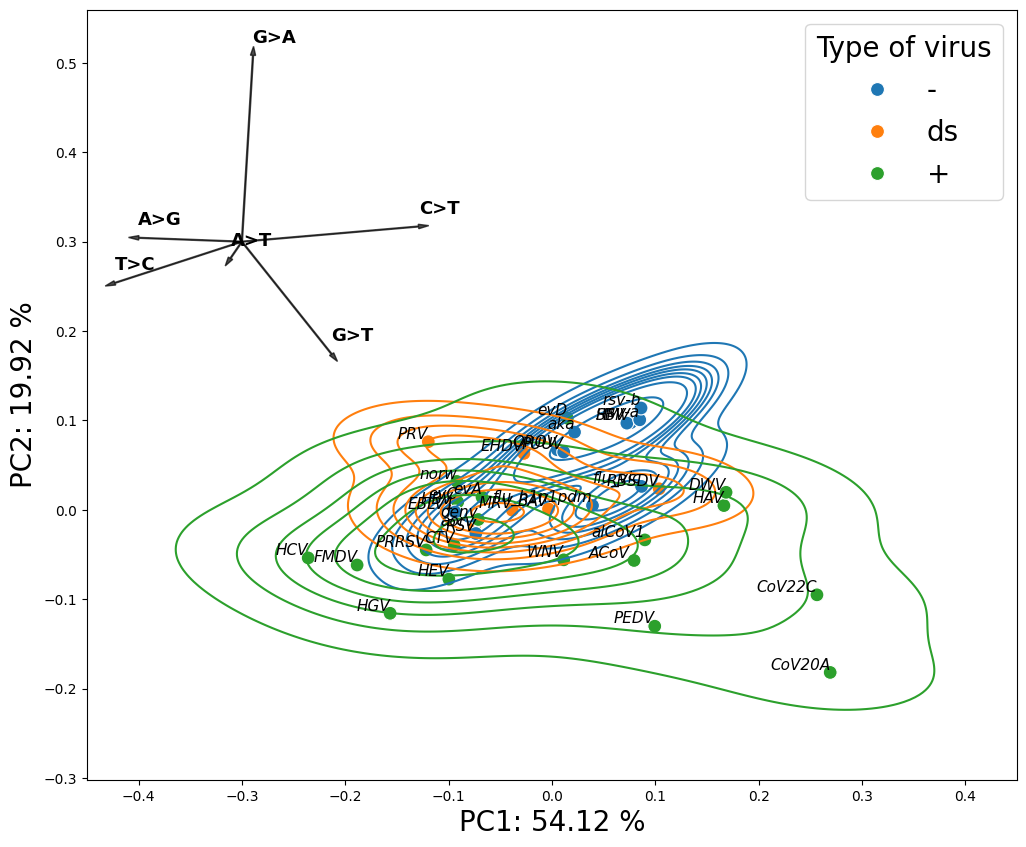

In [66]:
plt.figure(figsize=(12, 10))
sns.kdeplot(pca_data_plot, x='pc1', y='pc2', hue='Type',  hue_order=['-', 'ds', '+'])
ax = sns.scatterplot(pca_data_plot, x='pc1', y='pc2', hue='Type', hue_order=['-', 'ds', '+'], s=100)

for _, row in pca_data_plot.iterrows():
    ax.text(row['pc1'], row['pc2'], row['virusname'], fontsize=11, style='oblique', ha='right', va='bottom')

# Calculate the projections of the original features (columns) onto the PCA plot
# Use the loadings (PCA components) for PC1 and PC2
feature_vectors = model.components_[:2, :]  # shape (2, 12)
scaling = 0.25  # scale factor for better visualization

for i, feature in enumerate(sbs12_ordered):
    x = feature_vectors[0, i] * scaling
    y = feature_vectors[1, i] * scaling
    if (x**2 + y**2)**0.5 < 0.02:  # filter out small vectors
        continue
    ax.arrow(-0.3, 0.3, x, y, color='k', alpha=0.7, head_width=0.005, head_length=0.01, linewidth=1)
    ax.text((x-0.28), (y+0.32), feature, color='black', ha='center', va='center', fontsize=13, fontweight='bold')

ax.set_xlim(-0.45, 0.45)

ax.set_xlabel('PC1: {:.2f} %'.format(model.explained_variance_ratio_[0]*100), fontsize=20)
ax.set_ylabel('PC2: {:.2f} %'.format(model.explained_variance_ratio_[1]*100), fontsize=20)

plt.legend(title='Type of virus', fontsize=20, title_fontsize=20)
plt.savefig('./figures/PCA_virus_mutagenesis.pdf', bbox_inches='tight', pad_inches=0.7)

In [ ]:
model.components_

array([[ 0.01573922,  0.34722917, -0.0043703 , -0.00900471,  0.68366857,
         0.04303257, -0.05065382, -0.04409904, -0.4917405 , -0.39901322,
        -0.03597723, -0.05481165],
       [-0.01287181, -0.50303745,  0.00666897, -0.03554505,  0.06782997,
         0.83385091, -0.01108233, -0.07420107, -0.18457655,  0.01712875,
        -0.06090888, -0.04325567],
       [-0.17913203, -0.38891006, -0.01370175, -0.01457666,  0.6399791 ,
        -0.20870953, -0.07855113, -0.17606949,  0.52273622,  0.14363996,
        -0.09471859, -0.15198553],
       [-0.08170166,  0.57758141, -0.12243244, -0.07335403, -0.10672815,
         0.39301342, -0.10557049, -0.35384138,  0.45487628, -0.08910098,
        -0.22509683, -0.26764667],
       [-0.17094808,  0.20435147,  0.07355173, -0.04360475,  0.07759871,
        -0.01892336, -0.1786994 , -0.14487595, -0.37353918,  0.83070079,
        -0.11945741, -0.1361559 ],
       [-0.46719642,  0.04467844,  0.09427377, -0.03044615, -0.01270445,
         0.02746579,  

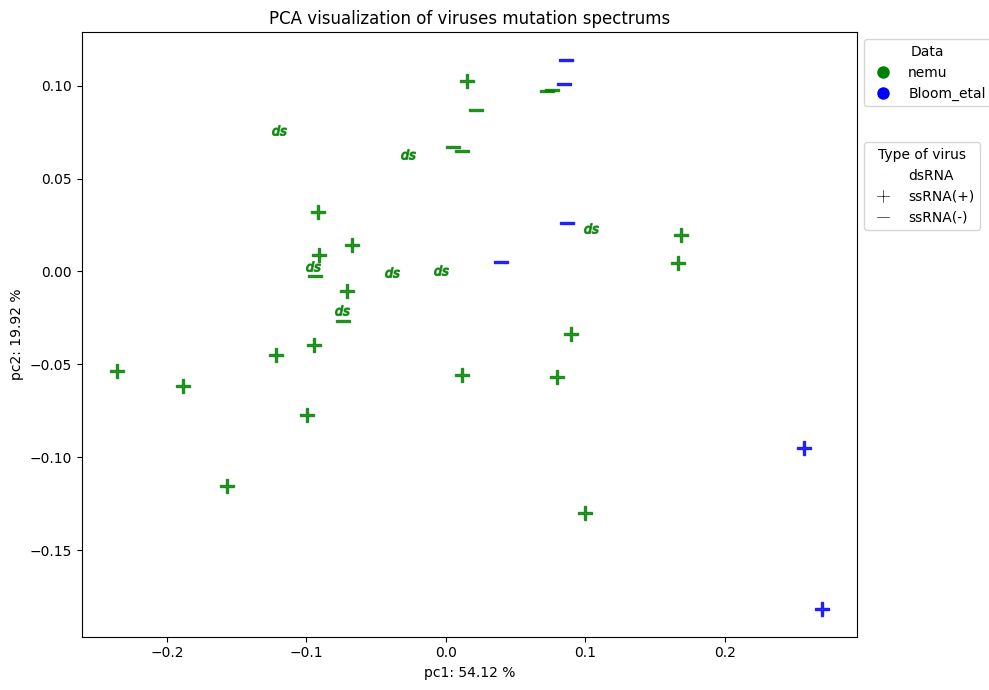

In [141]:
colors = {'nemu':'g', 'Bloom_etal':'b'}
markers={'ds':'$ds$', '+':'$+$', '-':'$-$'}
types_rna_virus = ['dsRNA', 'ssRNA(+)', 'ssRNA(-)']

# Create plot
fig, ax = plt.subplots(figsize=(10,7))

# Displaying points using colors and markers
for df in pca_data_plot['df'].unique():
    for Type in pca_data_plot['Type'].unique():
        indices = (pca_data_plot['df'] == df) & (pca_data_plot['Type'] == Type)
        ax.scatter(pca_data_plot.loc[indices, 'pc1'], pca_data_plot.loc[indices, 'pc2'],
                   s=100, # dot size
                   alpha=0.8, # непрозрачность
                   c=colors[df], # цвет точки
                   marker=markers[Type] # форма точки
                   )

# Отображаем легенду для цвета
handles_color = [plt.Line2D([0], [0], marker='o', color='w', label=color, markerfacecolor=colors[color], markersize=10) for color in colors]
legend_color = ax.legend(handles=handles_color, title="Data", loc="upper left", bbox_to_anchor=(1, 1))

# Добавляем легенду для типов маркеров
handles_marker = [plt.Line2D([0], [0], marker=markers[marker], color='w', label=type_rna_vir, markerfacecolor='k', markersize=10) for type_rna_vir, marker in zip(types_rna_virus, markers)]
legend_marker = ax.legend(handles=handles_marker, title="Type of virus", loc="upper left", bbox_to_anchor=(1, 0.83))

# # Добавляем обе легенды
ax.add_artist(legend_color)
# ax.add_artist(legend_marker)

ax.set_xlabel('pc1: {:.2f} %'.format(model.explained_variance_ratio_[0]*100))
ax.set_ylabel('pc2: {:.2f} %'.format(model.explained_variance_ratio_[1]*100))
ax.set_title('PCA visualization of viruses mutation spectrums')

# plt.subplots_adjust(right=0.7)
fig.tight_layout()
plt.show()

# fig.savefig('../viral_spectra/figures/PCA_nemu_kelly.pdf', bbox_inches='tight', pad_inches=0.7)

## Mutations that most affected components

In [142]:
n_pcs= model.components_.shape[0]
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

In [143]:
initial_feature_names = list(pca_data_only.columns)
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

df = pd.DataFrame(dic.items())

In [144]:
df

,0,1
0,PC1,C>T
1,PC2,G>A
2,PC3,C>T
3,PC4,G>T
4,PC5,A>G
5,PC6,T>A
6,PC7,C>A
7,PC8,C>G
8,PC9,G>C
9,PC10,T>G


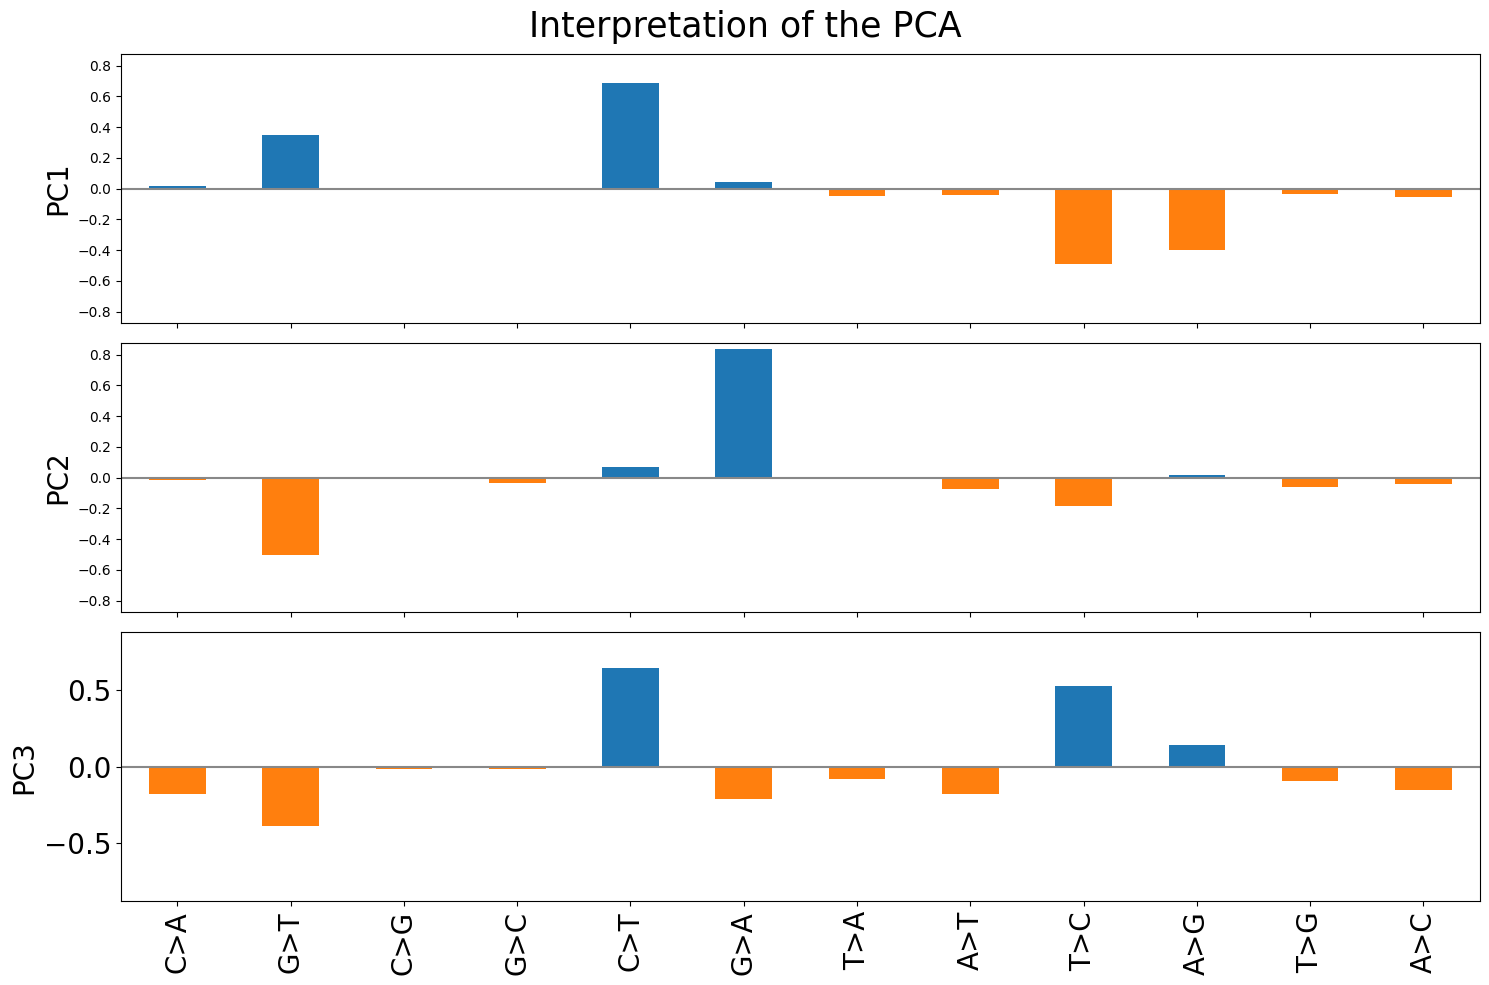

In [145]:
loadings = pd.DataFrame(model.components_[0:3, :], 
                        columns=pca_data_only.columns)
maxPC = 1.05 * np.max(np.max(np.abs(loadings.loc[0:3, :])))
f, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}', fontsize=20)
    ax.set_ylim(-maxPC, maxPC)
plt.suptitle('Interpretation of the PCA', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
plt.show()

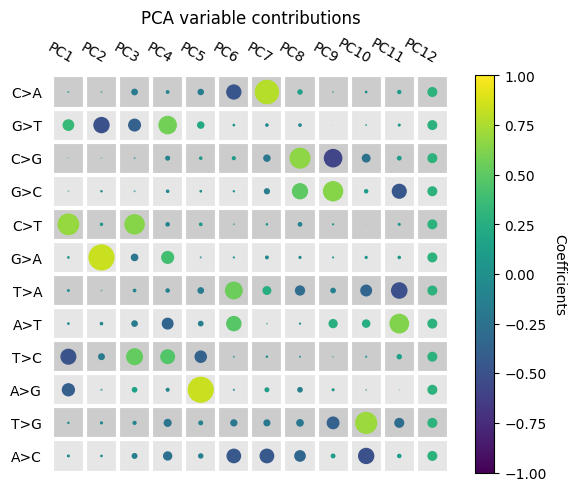

In [146]:
kwargs = {
    'heatmap': {
        'vmin': -1,
        'vmax': 1,
    },
}



pca_loadings_map(
    model,
    pca_data_only.columns,
    bubble=True,
    annotate=False,
    **kwargs
)
plt.suptitle('PCA variable contributions')
plt.show()

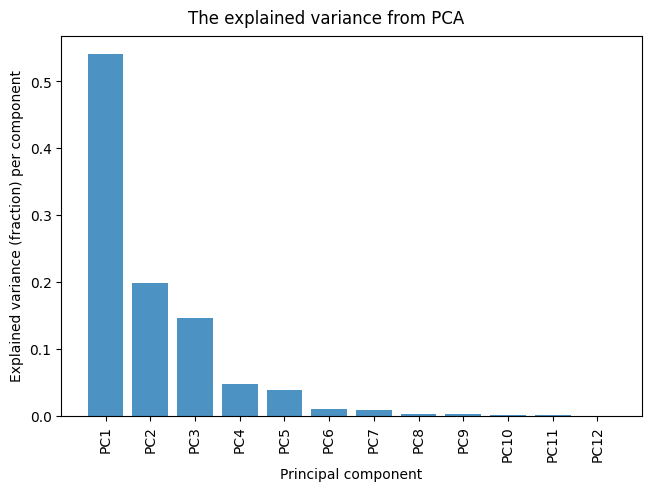

In [147]:
pca_explained_variance_bar(model, alpha=0.8)
plt.suptitle('The explained variance from PCA')
plt.show()